# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


В информации мы вдим, что в таблице есть пропущенные значени. Они находятся в столбце, обозначающем количество недвижимости у клиента. Скорее всего пропуски означают отсутсвие у клиента недвижимости. 
Заполним пропуски нулями и приедем к целому значению.


In [5]:
data = data.fillna(0)
data['Tenure'] = data['Tenure'].astype('int')

#### Подготовка данных

Вручную заменим значения в столбце "gender" на 0 и 1.


Методом ОНЕ добавим в таблицу новые дамми-признаки. При этом избавимся от столбца с "surname", "customerid" и "rownumber", так как они не влияют на 
финальное решение. 

In [6]:
data = data.replace('Male', 0)
data = data.replace('Female', 1)
data = pd.get_dummies(data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1), drop_first=True)

#### Выделим цели и признаки.

In [7]:
features = data.drop('Exited', axis=True)
target = data['Exited']

features_train, new_features, target_train, new_target = train_test_split(features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = (train_test_split(new_features, 
                                                                            new_target, 
                                                                            test_size=0.5, 
                                                                            random_state=42))

#### Маштабирование признаков

Так как у нас есть признаки с большим разбросом данных проведем стандартизацию данных. 
Из таблицы видно,что данные, которые требуют маштабирования находятся в столбцах: "CreditScore", "Age", "Balance" и "EstimatedSalary

In [8]:
sc_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[sc_columns])
features_train[sc_columns] = scaler.transform(features_train[sc_columns])
features_valid[sc_columns] = scaler.transform(features_valid[sc_columns])

Проверим, есть ли дисбаланс у классов.

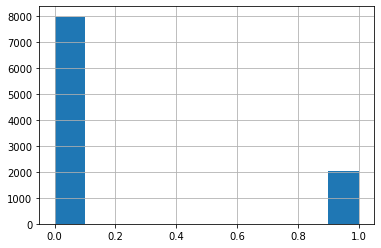

0    7963
1    2037
Name: Exited, dtype: int64


In [9]:
data['Exited'].hist()
plt.show()

print(data['Exited'].value_counts())

Из графика видно, что отрицательных классов почти в 4 раза больше, чем положительных.

# 2. Исследование задачи

In [10]:
%%time

for n in range(50,100,10):
    for i in range(10,18,2):
        model = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=i)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        print('F1 = ', f1, 'при n =', n, 'i = ', i)

F1 =  0.5582191780821918 при n = 50 i =  10
F1 =  0.566610455311973 при n = 50 i =  12
F1 =  0.5442404006677796 при n = 50 i =  14
F1 =  0.5398373983739837 при n = 50 i =  16
F1 =  0.5606837606837607 при n = 60 i =  10
F1 =  0.5641891891891891 при n = 60 i =  12
F1 =  0.5581395348837209 при n = 60 i =  14
F1 =  0.5451559934318556 при n = 60 i =  16
F1 =  0.5517241379310345 при n = 70 i =  10
F1 =  0.5627118644067797 при n = 70 i =  12
F1 =  0.5579119086460033 при n = 70 i =  14
F1 =  0.549342105263158 при n = 70 i =  16
F1 =  0.5504273504273504 при n = 80 i =  10
F1 =  0.5641891891891891 при n = 80 i =  12
F1 =  0.5620915032679739 при n = 80 i =  14
F1 =  0.548440065681445 при n = 80 i =  16
F1 =  0.5498281786941581 при n = 90 i =  10
F1 =  0.5617597292724196 при n = 90 i =  12
F1 =  0.5625000000000001 при n = 90 i =  14
F1 =  0.5529801324503312 при n = 90 i =  16
CPU times: user 12.4 s, sys: 80 ms, total: 12.5 s
Wall time: 12.6 s


Лучший результат у случайного леса с количество деревьев = 50 и максимальной глубиной = 12.
Проверим модель на тестовой выборке.

In [11]:
model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=12)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
# используем модель случайного леса с количество деревьев = 50 и максимальной глубиной = 12


f1 = f1_score(target_test, predictions)
probabilities = model.predict_proba(features_test)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
# считаем значения F1-меры и AUC-ROC






Выведем значения F1-меры, AUC-ROC, матрицу ошибок, полноту и точность, а также нарисуем граффик ROC-кривой

F1 =  0.37037037037037035
AUC ROC =  0.6567138201747889

Матрица ошибок
[[1010  560]
 [ 205  225]]

Полнота =  0.5232558139534884
Точность = 0.28662420382165604


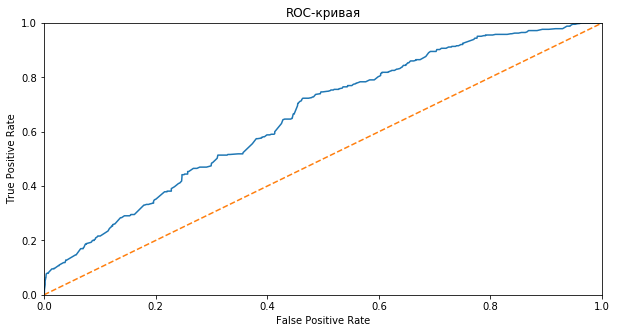

In [12]:
print('F1 = ', f1)
print('AUC ROC = ', auc_roc)
print( )
print('Матрица ошибок')
print(confusion_matrix(target_test, predictions))
print( )
print('Полнота = ', recall_score(target_test, predictions))
print('Точность =', precision_score(target_test, predictions))



fpr, tpr, thresholds =  roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.plot([0, 1], [0, 1], linestyle='--') # Случайный классификатор.

plt.show()

#### Вывод.

- Построив первую модель, мы видим, что F1-мера имеет не высокое значение: на валидационной выборке - 0.56, на тестовой - 0.37. 
- Постороив матрицу ошибок мы видим явний дисбаланс классов: отрицательны классов почти в 4 раза больше, чем положительных. Так же модель делает много ошибок
- Но модель уже лучше случайной. Это видно из граффика "ROC-кривая" и значения AUC-ROC.


Нужно улучшать модель путем устарнения дисбаланса.

# 3. Дисбаланс классов

Используем технику взвешивания классов.

In [13]:
model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=12, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

f1 = f1_score(target_valid, predictions)
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


print('F1 = ', f1)
print('AUC ROC = ', auc_roc)

F1 =  0.5610098176718092
AUC ROC =  0.8341106237816764


Модель лучше не стала. Попробуем метод увеличения выборки(upsampling).

In [14]:
def upsample(features, target, repeat):
    """Создадим функцию 'upsample' которая создает новые признаки и цели с 
    одинаковым количеством отрицательных и положительных классов. 
    Она получает на вход признаки(features), цели(target), и количество повторов(repeat)
    Возвращает увеличенные признаки(features_upsampled) и цели(target_upsamled)"""
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsamled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsamled = shuffle(features_upsampled, target_upsamled, random_state=42)
    
    return features_upsampled, target_upsamled

In [15]:
features_train_upsampled, target_train_upsamled = upsample(features, target, 4)
features_valid_upsampled, target_valid_upsamled = upsample(features, target, 4)

In [16]:
model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=12)
model.fit(features_train_upsampled, target_train_upsamled)
predictions = model.predict(features_valid_upsampled)

f1 = f1_score(target_valid_upsamled, predictions)
probabilities = model.predict_proba(features_valid_upsampled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid_upsamled, probabilities_one_valid)



print('F1 = ', f1)
print('AUC ROC = ', auc_roc)

F1 =  0.9433040078201368
AUC ROC =  0.9883343009282438


F1 =  0.9433040078201368
AUC ROC =  0.9883343009282438

Матрица ошибок
[[7463  500]
 [ 428 7720]]

Полнота =  0.9474717722140402
Точность = 0.9391727493917275


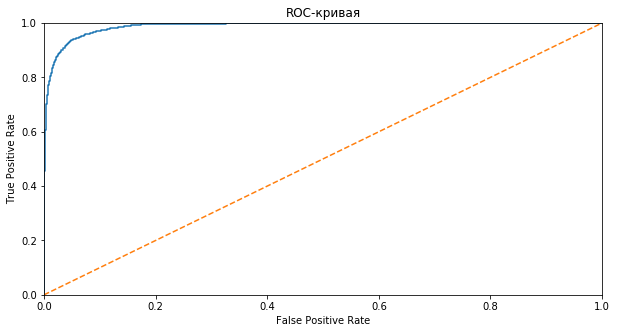

In [17]:
print('F1 = ', f1)
print('AUC ROC = ', auc_roc)
print( )
print('Матрица ошибок')
print(confusion_matrix(target_valid_upsamled, predictions))
print( )
print('Полнота = ', recall_score(target_valid_upsamled, predictions))
print('Точность =', precision_score(target_valid_upsamled, predictions))


fpr, tpr, thresholds =  roc_curve(target_valid_upsamled, probabilities_one_valid)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.plot([0, 1], [0, 1], linestyle='--') # Случайный классификатор.

plt.show()

Используя метод upsampling мы получили очень хорошую модель. Попробуем совместить оба способа.

In [18]:
model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=12, class_weight='balanced')
model.fit(features_train_upsampled, target_train_upsamled)
predictions = model.predict(features_valid_upsampled)

f1 = f1_score(target_valid_upsamled, predictions)
probabilities = model.predict_proba(features_valid_upsampled)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid_upsamled, probabilities_one_valid)



print('F1 = ', f1)
print('AUC ROC = ', auc_roc)
print()
print('Матрица ошибок')
print(confusion_matrix(target_valid_upsamled, predictions))

F1 =  0.9436748642216392
AUC ROC =  0.9883247451964107

Матрица ошибок
[[7456  507]
 [ 416 7732]]


####  Вывод.

Используя функции upsampling и технику взвешивания классов мы получили самую лучшую модель с наименьшим количеством ошибок, что видно в "Матрице ошибок" и с наибольшими значениями F1-меры и AUC ROC.

Проверим модель на тестовой выборке.

# 4. Тестирование модели

In [19]:
predictions = model.predict(features_test)

f1 = f1_score(target_test, predictions)
probabilities = model.predict_proba(features_test)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('F1 = ', f1)
print('AUC ROC = ', auc_roc)
print('Accuracy = ', accuracy_score(target_test, predictions))
print()
print('Матрица ошибок')
print(confusion_matrix(target_test, predictions))



F1 =  0.8814655172413792
AUC ROC =  0.989842986224263
Accuracy =  0.945

Матрица ошибок
[[1481   89]
 [  21  409]]


# Вывод.

Протестировав модель на тестовой выборке, мы получили хорошие результаты. Значение F1-меры = 0.88, а значение AUC ROC приближается к 1, что говорит от том, что эта модель хорошо предсказывает истино положительные, и почти не делает ошибок.
Значение Accarucy так же на высоком уровне.

Считаю, что данную модель можно использовать в продакшене.